# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

# Projeto de Aprendizado Profundo

## Intuito

* Problema: Agências de notícias, bibliotecas e arquivos governamentais possuem milhões de imagens não classificadas. Procurar manualmente fotos de presidentes pode ser uma tarefa bastante lenta.
* Solução: Desenvolver um modelo de aprendizado profundo capaz de ingerir imagens e classificá-los como os últimos 5 presidentes brasileiros ou não.

## Instalações e importações

In [1]:
%%capture
!pip install icrawler
!pip install facenet-pytorch

**----------- Se a célula abaixo der erro, reinicie a sessão e execute as células abaixo sem rodar a célula acima. -----------**

In [1]:
import os
import re
import copy
import time
import torch
import random
import shutil
import logging
import numpy as np
import seaborn as sns
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from sklearn.metrics import confusion_matrix
from icrawler.builtin import BingImageCrawler
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

## Hiperparâmetros

In [2]:
TEST_SPLIT = 0.7                                                                # 70% treino
VAL_SPLIT  = 0.15                                                               # 15% de teste, 15% de validação
BATCH_SIZE = 32                                                                 # Tamanho do lote (batch) usado em cada atualização de gradiente
NUM_EPOCHS = 50                                                                 # Número de epocas de treino
LEARNING_RATE = 0.001                                                           # Taxa de aprendizado
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

## Funções e classes auxiliares

In [3]:
class CleanLogHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        # Grupo 1 (\d+):   Código de status (ex: 403)
        # Grupo 2 ([^/]+): Domínio do site  (ex: upload.wikimedia.org)
        self.regex = re.compile(r"Response status code (\d+), file https?://([^/]+)")

    def emit(self, record):
        msg = self.format(record)

        match = self.regex.search(msg)

        if match:
            status_code = match.group(1)
            domain = match.group(2)

            if status_code == '400':
                print(f"    -> [Downloader] Falha: O site '{domain}' não entendeu a requisição (400 Bad Request).")
            elif status_code == '401':
                print(f"    -> [Downloader] Falha: O site '{domain}' requer autenticação (401 Unauthorized).")
            elif status_code == '403':
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' proibiu o acesso (403 Proibido).")
            elif status_code == '404':
                print(f"    -> [Downloader] Falha ao baixar porque a imagem no site '{domain}' não foi encontrada (404 Link Quebrado).")
            elif status_code == '406':
                print(f"    -> [Downloader] Falha: O site '{domain}' não tem um formato de resposta aceitável (406 Not Acceptable).")
            elif status_code == '429':
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' nos bloqueou por muitas requisições (429 Rate Limit).")
            elif status_code == '504':
                print(f"    -> [Downloader] Falha: O servidor do site '{domain}' demorou demais (504 Gateway Timeout).")
            else:
                # Mensagem genérica para outros códigos (400, 401, 500, etc.)
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' deu um erro (Código {status_code}).")

        elif "Read timed out" in msg:
            print("    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).")

        elif "CERTIFICATE_VERIFY_FAILED" in msg:
            print("    -> [Downloader] Falha ao baixar devido a um erro no certificado de segurança (SSL) do site.")

In [4]:
downloader_logger = logging.getLogger('downloader')
downloader_logger.setLevel(logging.ERROR)
downloader_logger.handlers = []
downloader_logger.addHandler(CleanLogHandler())
downloader_logger.propagate = False

In [5]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

In [6]:
def predict_image(image_path, model, transform, class_names):
    """
    Carrega uma imagem, aplica as transformações e retorna a predição do modelo.
    """
    # Carregando a imagem
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

    # Aplicando as transformações de validação
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(DEVICE)

    # Modelo em avaliação
    model.eval()

    # Prediz
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)

    # Retorna o nome da classe
    return class_names[predicted_idx.item()]

In [7]:
def visualize_augmentations(dataset, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    for i in range(n_samples):
        img_tensor, label = dataset[random.randint(0, len(dataset)-1)]

        img_tensor = inv_normalize(img_tensor)

        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(class_names[label])

    plt.show()

## Dados

### Obtenção

Irei buscar por 5 presidentes desse século e uma classe extra "Alguém" para ensinar ao modelo o que não é presidente.

In [8]:
search_terms = {
    "Lula": "Luís Inácio Lula da Silva rosto oficial",
    "Bolsonaro": "Jair Bolsonaro foto oficial rosto",
    "Temer": "Michel Temer",
    "Dilma": "Dilma Rousseff foto oficial rosto",
    "Fernando": "Fernando Henrique Cardoso rosto",
    "Alguém": "CEO headshot"                                                    # Busquei por imagens de CEOs pois normalmente estão de terno e gravata.
}

In [9]:
def download_and_verify_images(keyword, folder, n_total=100):
    os.makedirs(folder, exist_ok=True)

    filtros = dict(
        type='photo',
        layout='tall'
    )

    imagens_validas = 0
    file_index_offset = 0

    print(f"Baixando imagens de '{keyword}'. Alvo: {n_total} imagens válidas.")
    while imagens_validas < n_total:
        imagens_faltando = n_total - imagens_validas

        compensacao = imagens_faltando + 10

        print(f"\nAlvo: {n_total} | Válidas: {imagens_validas} | Buscando mais {compensacao}...")

        imagens_antes_do_crawl = set(os.listdir(folder))

        try:
            crawler = BingImageCrawler(storage={'root_dir': folder})
            crawler.crawl(keyword=keyword,
                          filters=filtros,
                          max_num=compensacao,
                          file_idx_offset=file_index_offset)
        except Exception as e:
            print(f"  -> [Crawler] Erro Inesperado: {e}. Tentando novamente...")
            time.sleep(5)
            continue

        imagens_depois_do_crawl = set(os.listdir(folder))

        novas_imagens = imagens_depois_do_crawl - imagens_antes_do_crawl

        if not novas_imagens:
            print("  -> [Crawler] Não encontrou novas imagens. Parando.")
            break


        print(f"  -> {len(novas_imagens)} baixadas. Verificando...")

        novas_imagens_validas_encontradas = 0
        for filename in novas_imagens:
            file_path = os.path.join(folder, filename)
            if not os.path.isfile(file_path):
                continue

            try:
                with Image.open(file_path) as img:
                    img.load()
                # Imagem é válida!
                novas_imagens_validas_encontradas += 1
            except (IOError, OSError, Image.UnidentifiedImageError):
                # Imagem corrompida.
                print(f"    -> Removendo imagem corrompida: {filename}")
                os.remove(file_path)

        print(f"  -> Verificação concluída: {novas_imagens_validas_encontradas} novas imagens válidas.")
        imagens_validas += novas_imagens_validas_encontradas

        # Atualiza o offset para o próximo loop, para evitar sobrescrever arquivos
        file_index_offset = len(os.listdir(folder))

    print(f"\n--- Download concluído para '{keyword}' ---")
    print(f"Total de imagens válidas na pasta: {imagens_validas}\n")

In [10]:
for label, term in search_terms.items():
    download_and_verify_images(term, f"data/presidents/{label}", n_total=100)

Baixando imagens de 'Luís Inácio Lula da Silva rosto oficial'. Alvo: 100 imagens válidas.

Alvo: 100 | Válidas: 0 | Buscando mais 110...
    -> [Downloader] Falha ao baixar porque a imagem no site 'upload.wikimedia.org' não foi encontrada (404 Link Quebrado).
    -> [Downloader] Falha ao baixar porque a imagem no site 'upload.wikimedia.org' não foi encontrada (404 Link Quebrado).
  -> 9 baixadas. Verificando...
  -> Verificação concluída: 9 novas imagens válidas.

Alvo: 100 | Válidas: 9 | Buscando mais 101...
    -> [Downloader] Falha ao baixar porque a imagem no site 'upload.wikimedia.org' não foi encontrada (404 Link Quebrado).
    -> [Downloader] Falha ao baixar porque a imagem no site 'upload.wikimedia.org' não foi encontrada (404 Link Quebrado).
  -> 9 baixadas. Verificando...
  -> Verificação concluída: 9 novas imagens válidas.

Alvo: 100 | Válidas: 18 | Buscando mais 92...
    -> [Downloader] Falha ao baixar porque a imagem no site 'upload.wikimedia.org' não foi encontrada (404 

### Visualização dos dados

In [11]:
def visualize_samples(root_dir, n_samples=5):
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 3*len(classes)))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        images = os.listdir(class_dir)

        # Pega amostras aleatórias (ou todas se tiver poucas)
        samples = random.sample(images, min(len(images), n_samples))

        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(class_name, fontsize=14, loc='left')
            except:
                pass

    plt.tight_layout()
    plt.show()

In [12]:
visualize_samples("data/presidents")

Output hidden; open in https://colab.research.google.com to view.

### Pré-processamento

#### Destacando as faces e desconsiderando o que não é rosto

In [13]:
def crop_and_save_faces(original_dir, processed_dir, mtcnn):
    if os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)

    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    total_faces = 0

    for class_name in classes:
        source_class_dir = os.path.join(original_dir, class_name)
        dest_class_dir = os.path.join(processed_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        print(f"Processando: {class_name}...")
        count = 0

        for img_name in os.listdir(source_class_dir):
            img_path = os.path.join(source_class_dir, img_name)

            try:
                img = Image.open(img_path).convert('RGB')
                # MTCNN detecta e salva já cortado
                # save_path define onde salvar. Retorna o path se sucesso.
                save_path = os.path.join(dest_class_dir, img_name)
                mtcnn(img, save_path=save_path)

                # Verifica se o arquivo foi criado (se o MTCNN achou rosto)
                if os.path.exists(save_path):
                    count += 1
            except Exception as e:
                # Ignora erros de leitura de arquivo
                continue

        print(f"  -> Rostos detectados e salvos: {count}")
        total_faces += count

    print(f"\nPré-processamento concluído! Total de faces no dataset final: {total_faces}")

In [14]:
# Inicializar MTCNN (Detector de rostos)
# margin=20 dá um respiro ao redor do rosto (pega um pouco do cabelo/queixo)
mtcnn = MTCNN(keep_all=False, select_largest=True, margin=20, device=DEVICE)

crop_and_save_faces("data/presidents", "data/presidents_cropped", mtcnn)

Processando: Bolsonaro...
  -> Rostos detectados e salvos: 102
Processando: Temer...
  -> Rostos detectados e salvos: 108
Processando: Lula...
  -> Rostos detectados e salvos: 108
Processando: Alguém...
  -> Rostos detectados e salvos: 107
Processando: Fernando...
  -> Rostos detectados e salvos: 98
Processando: Dilma...
  -> Rostos detectados e salvos: 108

Pré-processamento concluído! Total de faces no dataset final: 631


In [15]:
visualize_samples("data/presidents_cropped")

Output hidden; open in https://colab.research.google.com to view.

#### Data Augmentation

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),

        # Transformações geométricas (Posição/Formato)
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),

        # Transformações de cor e luz
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),

        # Simulação de problemas de qualidade na imagem
        transforms.RandomGrayscale(p=0.1),

        # Mudança de perspectiva
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),

        transforms.ToTensor(),

        # Apagamento aleatório
        # Força o modelo a reconhecer um presidente apenas por menos
        # características visto que o resto da face está coberta
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [17]:
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

### Divisão de treino e validação

In [18]:
full_dataset = datasets.ImageFolder("data/presidents_cropped")

train_size = int(TEST_SPLIT * len(full_dataset))
val_size   = int(VAL_SPLIT * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [19]:
train_data = TransformSubset(train_dataset, data_transforms['train'])
val_data   = TransformSubset(val_dataset, data_transforms['val'])
test_data  = TransformSubset(test_dataset, data_transforms['val'])

In [20]:
dataloaders = {
    'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2),
    'val':   DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    'test':  DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

In [21]:
class_names = full_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Alguém', 'Bolsonaro', 'Dilma', 'Fernando', 'Lula', 'Temer']


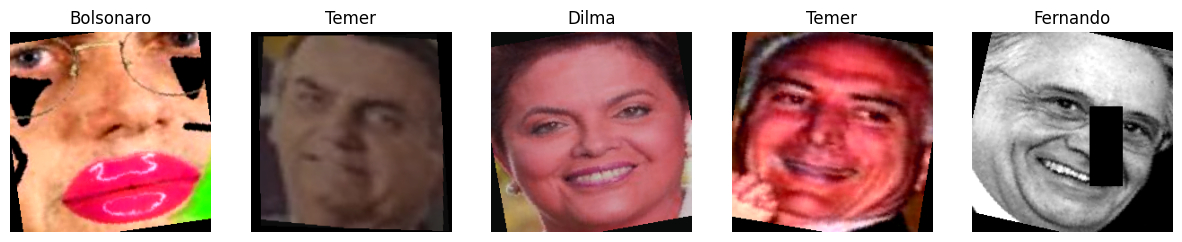

In [22]:
visualize_augmentations(train_data)

## Modelo

### Projetando o modelo

In [23]:
def get_model(num_classes):
    # Transfer Learning com ResNet18
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Congelando camadas iniciais (visto que já aprenderam o que é um rosto)
    for param in model.parameters():
        param.requires_grad = False

    # Substituir a última camada (visto que quero que aprendam a identificar rostos em específico)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model.to(DEVICE)

In [24]:
model = get_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


### Treinando o modelo

In [25]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Guardando o melhor modelo visto durante o treino
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterando
            for inputs, labels in loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy do modelo se ele for o melhor até agora
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Melhor Acurácia na Validação: {best_acc:4f}')

    # Carrega os pesos do melhor modelo
    model.load_state_dict(best_model_wts)
    return model, history

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

model, history = train_model(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], NUM_EPOCHS)

Epoch 1/50
----------
Train Loss: 1.7420 Acc: 0.2993
Val Loss: 1.6699 Acc: 0.3936

Epoch 2/50
----------
Train Loss: 1.4355 Acc: 0.4467
Val Loss: 1.4285 Acc: 0.4362

Epoch 3/50
----------
Train Loss: 1.2325 Acc: 0.5964
Val Loss: 1.2216 Acc: 0.5851

Epoch 4/50
----------
Train Loss: 1.0875 Acc: 0.6553
Val Loss: 1.0953 Acc: 0.5319

Epoch 5/50
----------
Train Loss: 0.9557 Acc: 0.7392
Val Loss: 1.1061 Acc: 0.5213

Epoch 6/50
----------
Train Loss: 0.9093 Acc: 0.7188
Val Loss: 0.9544 Acc: 0.6489

Epoch 7/50
----------
Train Loss: 0.8226 Acc: 0.7483
Val Loss: 1.0542 Acc: 0.5213

Epoch 8/50
----------
Train Loss: 0.7902 Acc: 0.7959
Val Loss: 0.9028 Acc: 0.6383

Epoch 9/50
----------
Train Loss: 0.7258 Acc: 0.7891
Val Loss: 0.9404 Acc: 0.6383

Epoch 10/50
----------
Train Loss: 0.7215 Acc: 0.7891
Val Loss: 0.8050 Acc: 0.7021

Epoch 11/50
----------
Train Loss: 0.6628 Acc: 0.8050
Val Loss: 0.8251 Acc: 0.7234

Epoch 12/50
----------
Train Loss: 0.6299 Acc: 0.8277
Val Loss: 0.7698 Acc: 0.7553

E

## Avaliação

### Curvas de treinamento

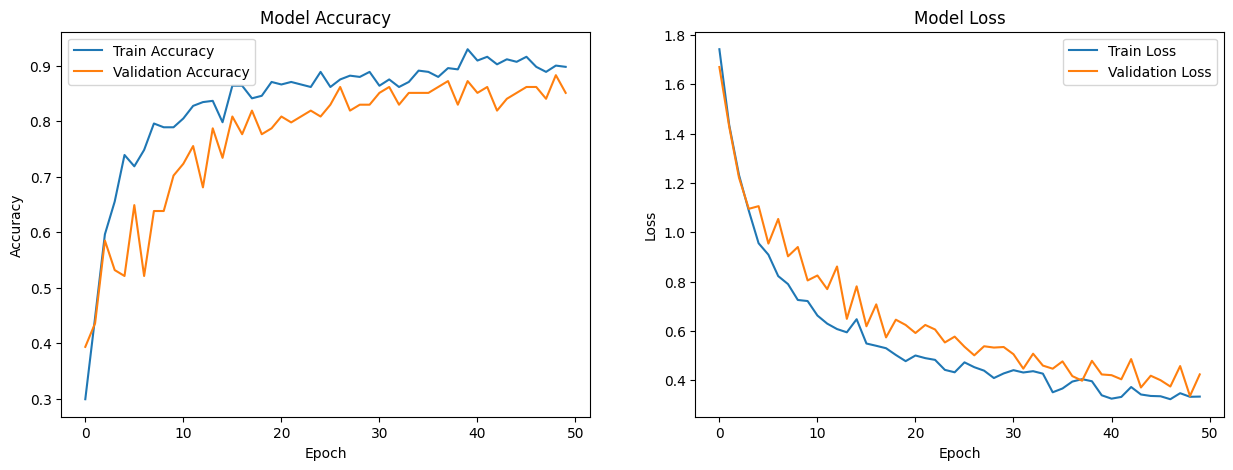

In [27]:
plot_history(history)

### Métricas

In [28]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct / total) * 100

In [29]:
# Avaliando no conjunto de TESTE (dados nunca vistos)
test_acc = evaluate_accuracy(model, dataloaders['test'])

print(f"Acurácia Final no Conjunto de Teste: {test_acc:.2f}%")

Acurácia Final no Conjunto de Teste: 89.58%


In [30]:
def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

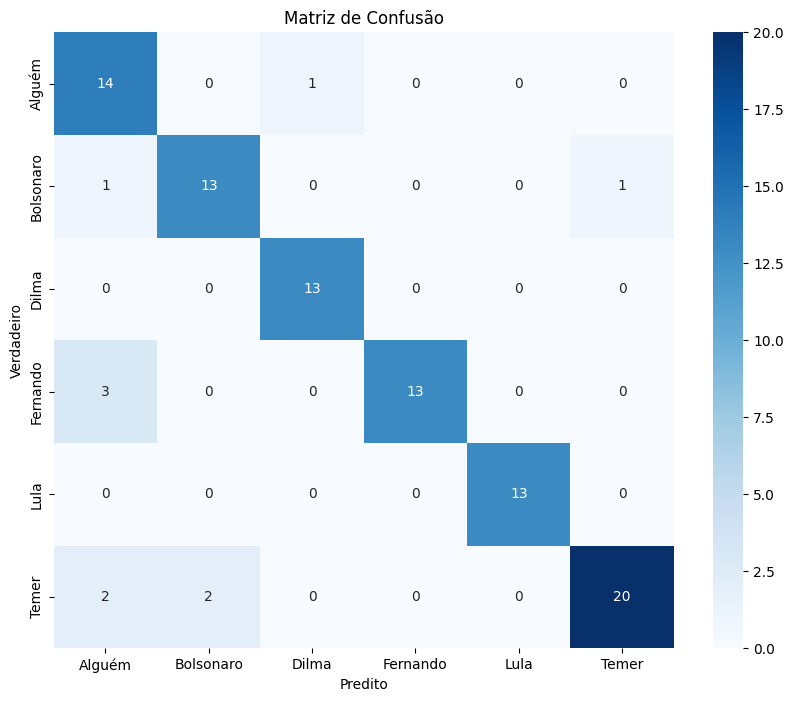

In [31]:
plot_confusion_matrix(model, dataloaders['test'], class_names)

### Análise dos resultados

* **Sobre as curvas:**
    * Observando os gráficos de Perda e Acurácia, nota-se uma convergência saudável. A *Validation Loss* decresce junto com a *Training Loss* até aproximadamente a época 20, onde estabiliza.
    * O fato da *Validation Accuracy* acompanhar a *Train Accuracy* (com uma leve distância) indica que o modelo conseguiu generalizar bem o aprendizado, sem sofrer de *Overfitting* severo (o que seria indicado se a *Validation Loss* começasse a subir enquanto o treino continuasse descendo).
    * As oscilações (formato "serrilhado") na curva de validação são esperadas dado o tamanho reduzido do dataset; cada lote de validação pode ter características muito variadas.

* **Sobre a matriz de confusão:**
    * O modelo treinado tem maior dificuldade em reconhecer as faces dos presidentes Michel Temer e Fernando Henrique Cardoso, acredito que isso ocorre porque essas classes tiveram mais imagens inválidas (pessoas que não pertencem à classe, faces de outros presidentes), enquanto isso o modelo aprendeu bem o padrão dos rostos dos demais presidentes.
* **Quanto à acurácia final:**
    * O modelo atingiu **89.58%** de acurácia no conjunto de teste (dados nunca vistos).
    * Considerando que a coleta foi automatizada via *crawler* e sem limpeza manual, esse resultado valida o uso da arquitetura ResNet18 e do *Transfer Learning*. O modelo é funcional, errando em casos de ambiguidade visual ou ruído nos dados.

### Erros e limitações

* A qualidade da classificação das imagens depende muito da base de dados que o crawler monta no passo dos Dados:
* * Se muitas imagens que não tem relevância são baixadas para uma classe em específico, essa classe vai sofrer durante o treinamento pois terá menos entradas válidas.
* * Muitos sites copiam as mesmas informações e as exibem então há uma alta chance do crawler baixar imagens duplicadas, isso é um problema pois pode violar a ineditude essencial para os dados de teste.
* * Inconsistentemente, o crawler baixa imagens de pessoas com o primeiro nome da busca, por exemplo, apenas o nome "Michel".

* Uma limitação extra que os modelos treinados aqui possuem é de que, se imagens de outros presidentes que não são os 5 que o modelo tentou aprender forem dispostas ao modelo, naturalmente, como nunca as viu, classificará esses outros presidentes como "Alguém", isto é, não são presidentes.

### Possíveis soluções

Imagino que posso resolver isso via remoção manual das imagens inválidas após a coleta do icrawler, mas isso é bem demorado já que teria que acessar cada imagem (mais ou menos 600).

Outra solução que pensei seria pegar um modelo treinado nesse notebook, salvá-lo, importá-lo e usá-lo após a coleta do icrawler para apagar as imagens inválidas, como uma espécie do próprio modelo ajudando a treinar uma melhor versão dele mesmo.

Também posso tentar outras configurações de hiperparâmetros, mas acredito que o problema é definitivamente a base de dados.

E sobre a limitação da quantidade de presidentes, posso adicionar mais classes e instruir o crawler à buscar imagens desses outros presidentes.